In [1]:
pip install python-dotenv langchain transformers gradio Ipython kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: async-timeout
    Found existing installation: async-timeout 5.0.1
    Uninstalling async-timeout-5.0.1:
      Successfully uninstalled async-timeout-5.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd 
import numpy as np
import re 
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# **Semantic book Recommender**

## 1-**Data cleaning**

### **Data investigation**

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dylanjcastillo/7k-books-with-metadata")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/7k-books-with-metadata


In [4]:
df = pd.read_csv(f'{path}/books.csv')

In [5]:
df.head(5)

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0


<Axes: >

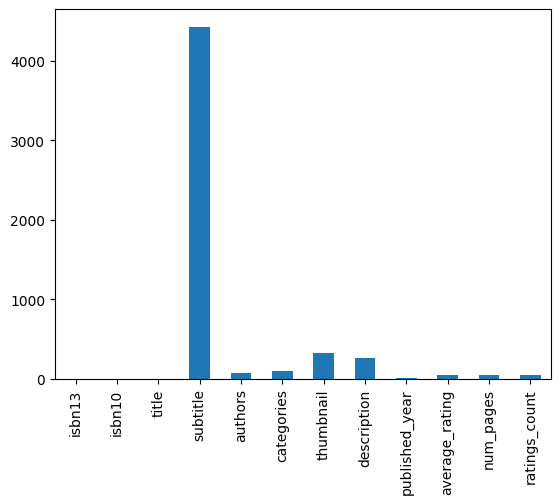

In [6]:
df.isna().sum().plot(kind='bar')

In [7]:
df.columns

Index(['isbn13', 'isbn10', 'title', 'subtitle', 'authors', 'categories',
       'thumbnail', 'description', 'published_year', 'average_rating',
       'num_pages', 'ratings_count'],
      dtype='object')

In [8]:
len(df['categories'].unique())

568

<Axes: xlabel='categories'>

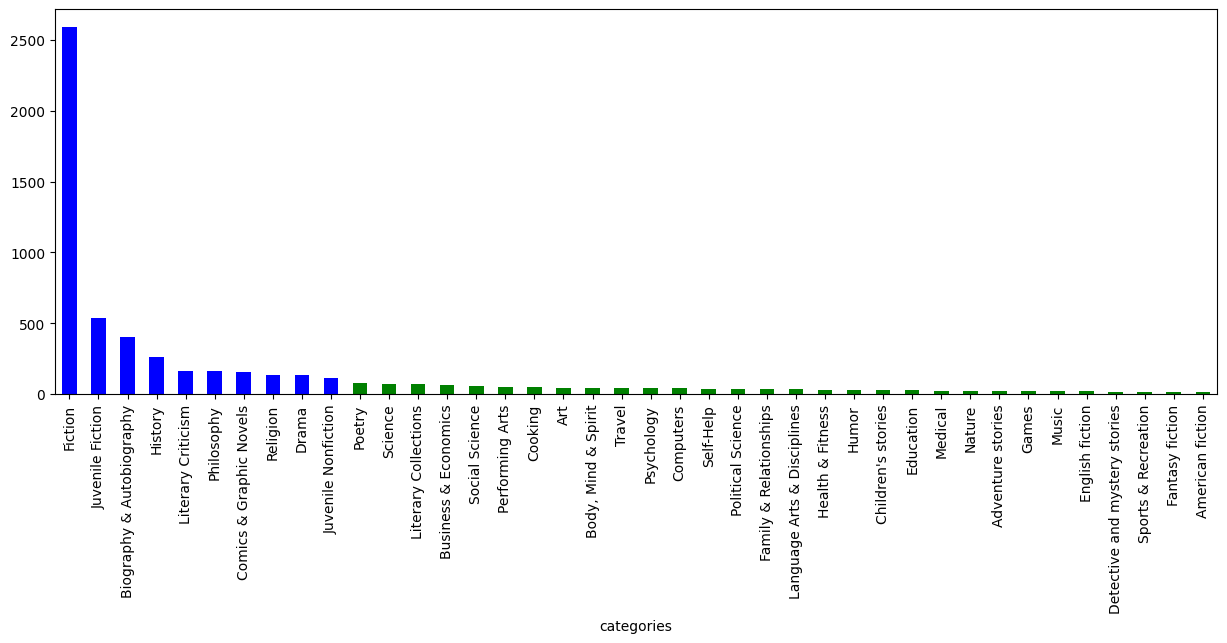

In [9]:
color = ['blue' if x > 100 else 'green' for x in df['categories'].value_counts()[:40] ]
plt.figure(figsize=(15,5))
df['categories'].value_counts()[:40].plot(kind='bar',color=color)

(array([1987.5, 1990. , 1992.5, 1995. , 1997.5, 2000. , 2002.5, 2005. ,
        2007.5, 2010. ]),
 [Text(1987.5, 0, '1987.5'),
  Text(1990.0, 0, '1990.0'),
  Text(1992.5, 0, '1992.5'),
  Text(1995.0, 0, '1995.0'),
  Text(1997.5, 0, '1997.5'),
  Text(2000.0, 0, '2000.0'),
  Text(2002.5, 0, '2002.5'),
  Text(2005.0, 0, '2005.0'),
  Text(2007.5, 0, '2007.5'),
  Text(2010.0, 0, '2010.0')])

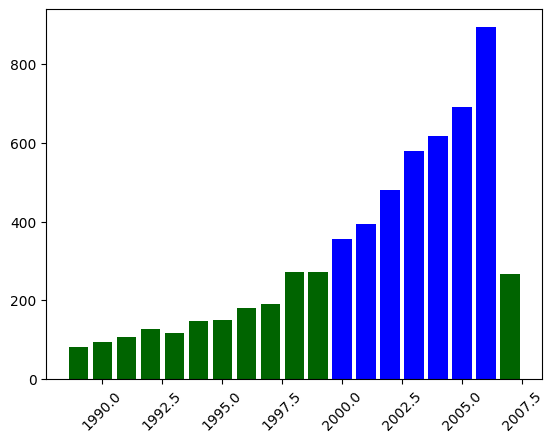

In [10]:
books_year_publishing = df['published_year'].value_counts()
books_year_publishing = books_year_publishing[books_year_publishing >= books_year_publishing.mean()]
c = ['blue' if x >= 300 else 'darkgreen' for x in books_year_publishing]
plt.bar(books_year_publishing.index,books_year_publishing.values,color=c)
plt.xticks(rotation=45)

Text(50.58159722222221, 0.5, 'Missing values')

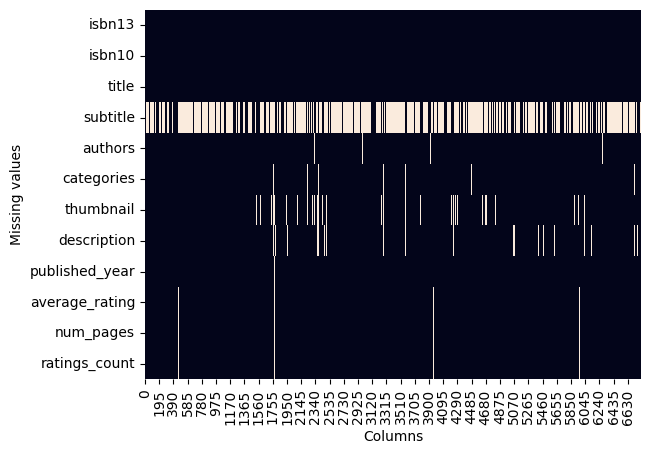

In [11]:
ax = plt.axes()

sns.heatmap(df.isna().transpose(),ax=ax,cbar=False)
plt.xlabel('Columns')
plt.ylabel('Missing values')

#### The heatmap reveals a pattern in missing data, so further investigation is needed to understand the cause and prevent bias during data cleaning.

In [12]:

df["missing_description"] = np.where(df['description'].isna(),1,0)
df['book_age'] = 2025-df['published_year']

<Axes: >

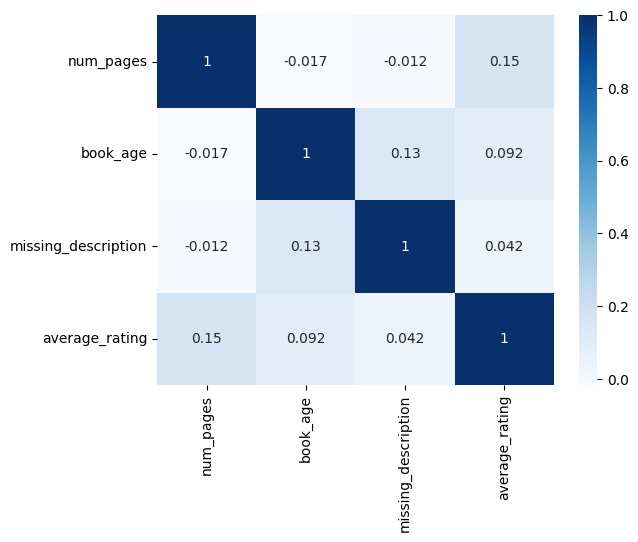

In [13]:
col_of_interest = ['num_pages',"book_age","missing_description","average_rating"]
sns.heatmap(df[col_of_interest].corr(method='spearman'),cmap='Blues',annot=True)

<Axes: >

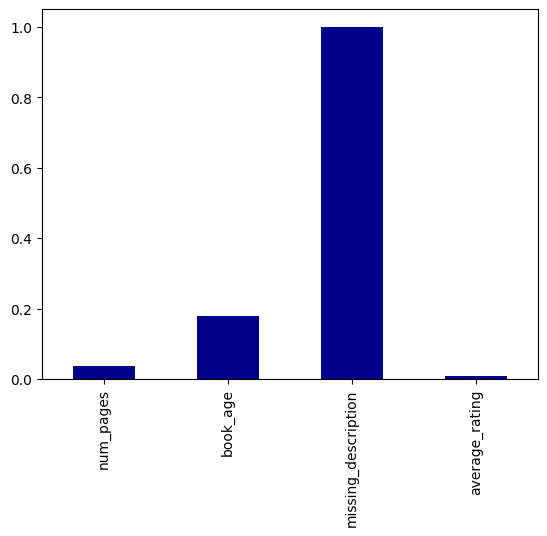

In [14]:
corr = df[col_of_interest].corrwith(df['missing_description'])
corr.plot(kind='bar',color='darkblue')

#### The correlation analysis reveals a negligible correlation between missing descriptions, number of pages, rating, and book age. This suggests our dataset is unlikely to be biased and is representative so we will drop the rows with na value in avg ratings and description and publicashed_year.

In [15]:
col_of_interest

['num_pages', 'book_age', 'missing_description', 'average_rating']

In [16]:
df = df[~(df["num_pages"].isna())&
                (~df["average_rating"].isna())&
                (~df["description"].isna())&
                (~df["published_year"].isna())]


In [17]:
df.head()

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,book_age
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,21.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,25.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0,0,43.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,32.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,23.0
